In [62]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings

warnings.simplefilter("ignore")


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
s11_folder = "/home/olga/code/droplet_rnaseq_workflows/bingwu-test-data/starsolo/S11_L001_R1_001Solo.out/"
matrix = f"{s11_folder}/matrix.mtx"
results_file = f"{s11_folder}/s11.h5ad"  # the file that will store the analysis results

scanpy==1.4.3 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


In [15]:
adata = sc.read_10x_mtx(s11_folder)
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AttributeError: 'AnnData' object has no attribute 'head'

In [16]:

adata

AnnData object with n_obs × n_vars = 737280 × 23433 
    var: 'gene_ids'

In [64]:
def add_counts_mito_genes(adata):

    mito_genes = adata.var_names.str.startswith('Mrpl')
    print(f"Number of mitochondrial genes: {sum(mito_genes)}")
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1
    return adata

adata = add_counts_mito_genes(adata)
adata.obs.head()

Number of mitochondrial genes: 47


,percent_mito,n_counts,n_genes
0,,,
AAACCTGAGCACACAG,0.001813,2206.0,916
AAACCTGAGCGGATCA,0.004272,2575.0,1131
AAACCTGAGGTGATAT,0.002859,4897.0,1816
AAACCTGAGTGAACAT,0.005179,2703.0,1205
AAACCTGGTAATCACC,0.004134,2419.0,1247


In [45]:
cell_with_two_counts = adata['AAACCTGAGAAACGCC', :]
cell_with_two_counts

View of AnnData object with n_obs × n_vars = 1 × 23433 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids'

In [46]:
adata.var[cell_with_two_counts.X > 0]

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


,gene_ids
1,
Scgb3a1,Scgb3a1
Agtr2,Agtr2


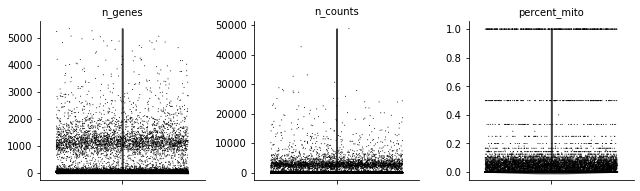

In [47]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

filtered out 451059 cells that have less than 1 counts


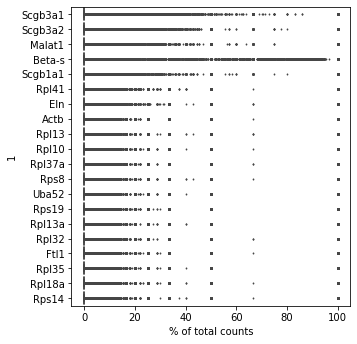

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [18]:
adata

AnnData object with n_obs × n_vars = 737280 × 23433 
    var: 'gene_ids'

In [23]:
286221 + 451059

737280

In [49]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 733702 cells that have less than 200 genes expressed
filtered out 8235 genes that are detected in less than 3 cells


In [51]:
print(adata)

AnnData object with n_obs × n_vars = 3578 × 15198 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_cells'


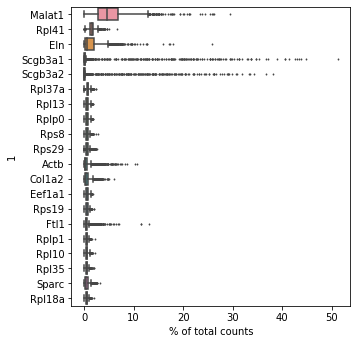

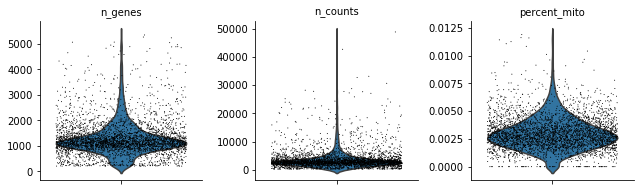

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


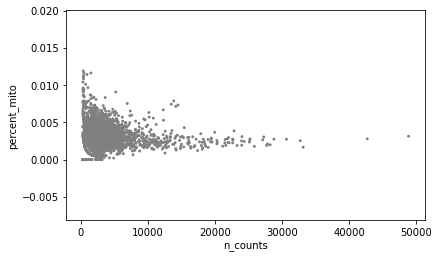

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


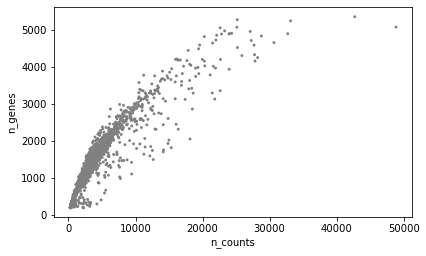

In [70]:
def n_cells_nonzero_counts(adata):
    summed = (adata.data > 0).sum(axis=1)
    return (summed > 0).sum()

def plot_qc(adata):
    sc.pl.highest_expr_genes(adata, n_top=20)

    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
         jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
        
plot_qc(adata)

In [66]:
cd ~/code/droplet_rnaseq_workflows/bingwu-test-data/starsolo/

/home/olga/code/droplet_rnaseq_workflows/bingwu-test-data/starsolo


========== S11_L001_R1_001Solo.out ==========
... reading from cache file cache/S11_L001_R1_001Solo.out-matrix.h5ad


/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


Number of mitochondrial genes: 47
Number of nonzero barcodes: 286221
--- Before filtering ---


/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Use X instead of data, data will be removed in the future.
  from ipykernel import kernelapp as app


filtered out 451059 cells that have less than 1 counts


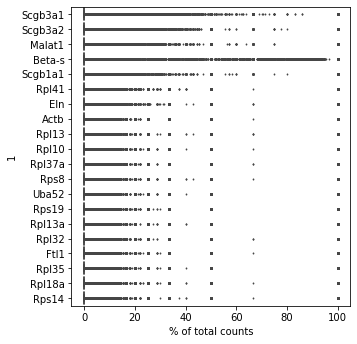

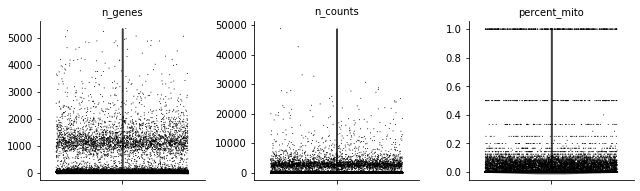

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


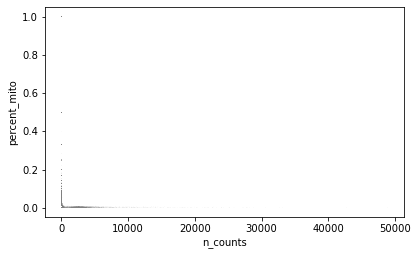

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


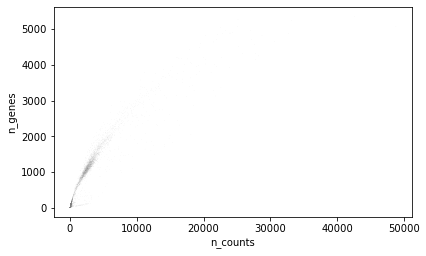

filtered out 733702 cells that have less than 200 genes expressed
filtered out 8235 genes that are detected in less than 3 cells
--- After filtering ---


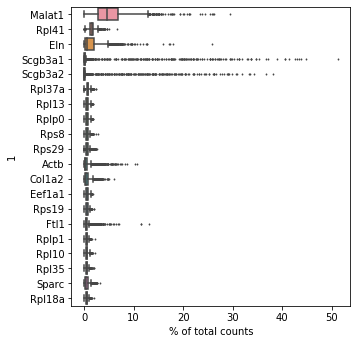

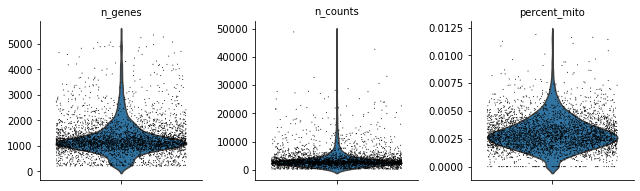

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


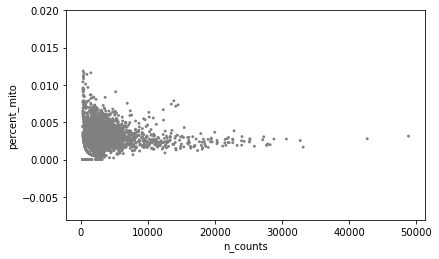

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


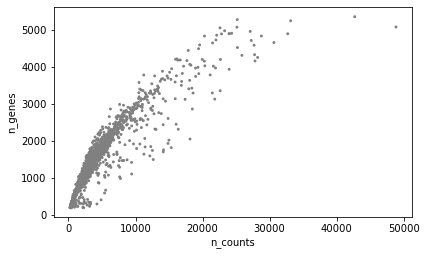

AnnData object with n_obs × n_vars = 3578 × 15198 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_cells'
========== S10_L001_R1_001Solo.out ==========
... writing an h5ad cache file to speedup reading next time
Number of mitochondrial genes: 47
Number of nonzero barcodes: 305308
--- Before filtering ---


/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Use X instead of data, data will be removed in the future.
  from ipykernel import kernelapp as app


filtered out 431972 cells that have less than 1 counts


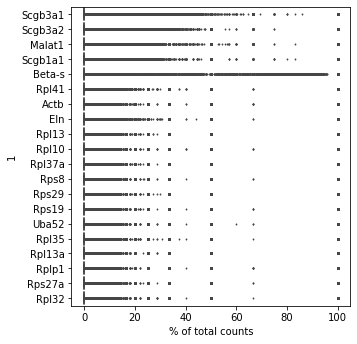

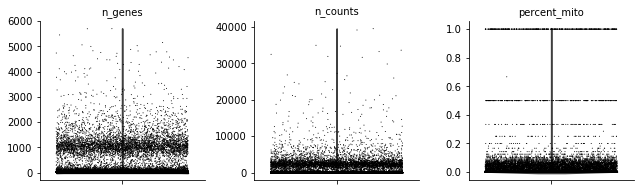

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


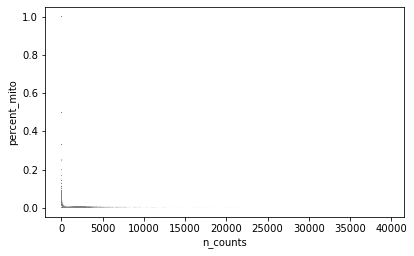

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


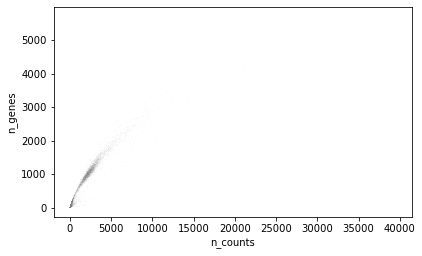

filtered out 731839 cells that have less than 200 genes expressed
filtered out 8139 genes that are detected in less than 3 cells
--- After filtering ---


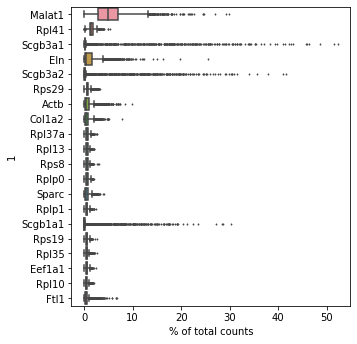

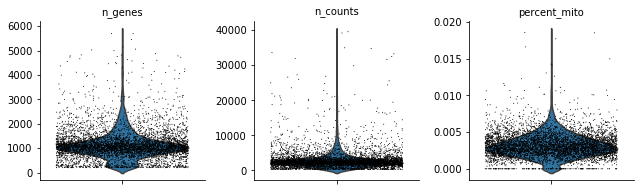

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


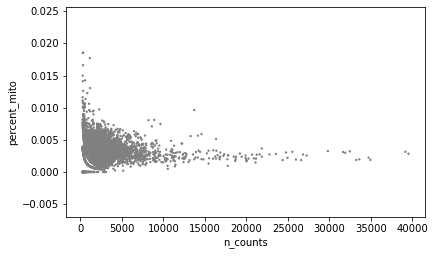

/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/olga/miniconda3/envs/maca/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


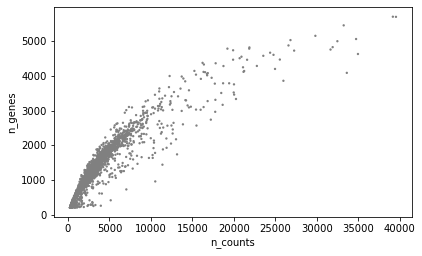

AnnData object with n_obs × n_vars = 5441 × 15294 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_cells'


In [71]:
def read_folder_and_plot_qc(folder):
    adata = sc.read_10x_mtx(folder, cache=True)
    adata = add_counts_mito_genes(adata)
    n_nonzero_barcodes = n_cells_nonzero_counts(adata)
    print(f"Number of nonzero barcodes: {n_nonzero_barcodes}")
    print('--- Before filtering ---')
    plot_qc(adata)
    
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    print('--- After filtering ---')
    plot_qc(adata)
    print(adata)

folders = 'S11_L001_R1_001Solo.out', 'S10_L001_R1_001Solo.out'
for folder in folders:
    print(f'========== {folder} ==========')
    read_folder_and_plot_qc(folder)

In [72]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [73]:
adata

View of AnnData object with n_obs × n_vars = 3376 × 15198 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_cells'

In [74]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)


Trying to set attribute `.obs` of view, making a copy.


In [75]:
sc.pp.log1p(adata)


In [76]:
adata.raw = adata


In [77]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


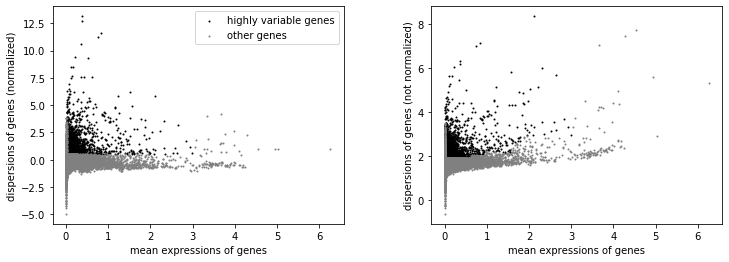

In [78]:
sc.pl.highly_variable_genes(adata)


In [79]:
adata = adata[:, adata.var['highly_variable']]


In [80]:
sc.pp.scale(adata, max_value=10)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.95)


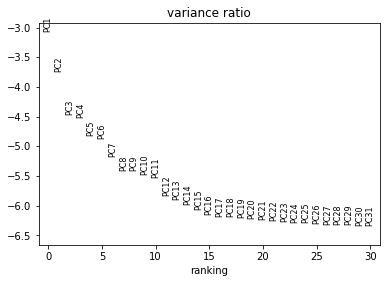

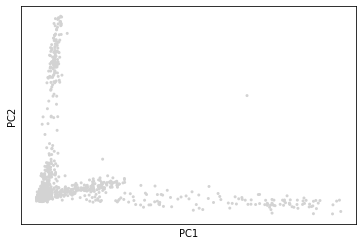

In [84]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(adata, log=True)

sc.pl.pca(adata)


In [85]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)


computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:03.00) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


computing UMAP
    using 'X_pca' with n_pcs = 10
    finished (0:00:07.95) --> added
    'X_umap', UMAP coordinates (adata.obsm)


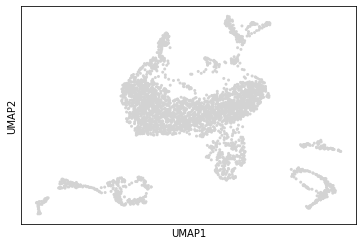

In [86]:
sc.tl.umap(adata)
sc.pl.umap(adata)


In [ ]:
sc.tl.leiden(adata)


In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)